In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [81]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import progressbar
import tensorflow as tf
import scipy




!rm -d -f -r rm *.zip
!rm -d -f -r rm *.npy


!rm -rf images
!rm -rf visualized


In [82]:
!wget -nc https://github.com/Nadiam75/DeepLearning_HW_2/raw/main/lsp_dataset/joints.mat
joints=scipy.io.loadmat('joints.mat')['joints']
# poses = joints [0:2 , : , :]
poses = joints

!wget  -nc https://github.com/Nadiam75/DeepLearning_HW_2/raw/main/lsp_dataset/images.zip
!unzip -q /content/images.zip

images_directory=os.listdir('/content/images')
target_size=(220,220)
resized_images=[]
resized_poses=[]
original_scale=[]
originalImages = []
dictionaryOfTrainImages = {}
dictionaryOfTestImages = {}
dictionaryOfImages = {}
# datasetDictionary = {}
for idx,x in progressbar.progressbar(enumerate(images_directory)):
    path=os.path.join('/content/images',x)
    image = plt.imread(path)
    dictionaryOfImages [idx ] = image

    height,width=image.shape[0],image.shape[1]
    # print(height)
    # print(width)

    # resized_poses(height/2)
    # scale_w,scale_h=220/width,220/height
    original_scale.append([width,height])
    # originalImages.appned(image)
    # resized_poses.append(   [poses[0,:,idx]*scale_w*2-1                 ,       poses[1,:,idx]*scale_h*2-1   ]   )
    # resized_poses.appned (  [   (poses[0,:,idx] - width/2 )/ width * 2  , (poses[1,:,idx]-height/2) /height*2 ]   )

    resized_poses.append(  [ poses[0,:,idx] / width , poses[1, : , idx]  / height ])
    image=cv2.resize(image,target_size,interpolation=cv2.INTER_AREA)
    resized_images.append(image)


    
resized_images=np.array(resized_images)


# print(resized_images.shape)
resized_poses=np.array(resized_poses)
# print(resized_poses.shape)
original_scale=np.array(original_scale)

# print(original_scale.shape)

trainkeys = np.arange(0 , 1600)
trainDict = {k: dictionaryOfImages[k] for k in trainkeys}

testkeys = np.arange(1600 , 2000)
testDict = {k: dictionaryOfImages[k] for k in testkeys}


np.save('Leeds Sports Dataset NPY.npy',resized_images[:1600])
np.save('Resized Poses.npy',resized_poses[:1600])
np.save('Image scale.npy',original_scale[:1600])
np.save('Leeds Sports Dataset NPY Test.npy',resized_images[1600:])
np.save('Resized Poses Test.npy',resized_poses[1600:])
np.save('Image scale Test.npy',original_scale[1600:])


!rm -d -f -r rm *.zip


File ‘joints.mat’ already there; not retrieving.

--2021-12-13 12:20:07--  https://github.com/Nadiam75/DeepLearning_HW_2/raw/main/lsp_dataset/images.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Nadiam75/DeepLearning_HW_2/main/lsp_dataset/images.zip [following]
--2021-12-13 12:20:07--  https://raw.githubusercontent.com/Nadiam75/DeepLearning_HW_2/main/lsp_dataset/images.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10319538 (9.8M) [application/zip]
Saving to: ‘images.zip’

images.zip          100%[===================>]   9.84M  --.-KB/s    in 0.1s    

2021-12-13 12:20:07 (97.0 MB/s) 

| |                       #                        | 1999 Elapsed Time: 0:00:02


In [84]:
resized_poses.shape


(2000, 2, 14)

In [85]:

x_train = resized_images[:1600]
y_train = resized_poses[:1600]
train_reconstruction_coefficient = original_scale[:1600]


x_test = resized_images[1600:]
y_test = resized_poses[1600:]
test_reconstruction_coefficient  =original_scale[1600:]

In [86]:
# def define_model(self):
#   #Changes made on model architecture
#   #LRN->BN, Pooling->Strided Convolution
#   model=tf.keras.models.Sequential()
#   model.add(tf.keras.layers.Conv2D(48,11,(4,4),padding='same',input_shape=(220,220,3)))
#   model.add(tf.keras.layers.BatchNormalization())
#   model.add(tf.keras.layers.ReLU())
#   model.add(tf.keras.layers.Conv2D(128,5,(2,2),padding='same'))
#   model.add(tf.keras.layers.BatchNormalization())
#   model.add(tf.keras.layers.ReLU())
#   model.add(tf.keras.layers.Conv2D(192,3,(2,2),padding='same',activation='relu'))
#   model.add(tf.keras.layers.Conv2D(192,3,(1,1),padding='same',activation='relu'))
#   model.add(tf.keras.layers.Conv2D(192,3,(1,1),padding='same',activation='relu'))
#   model.add(tf.keras.layers.MaxPooling2D())
#   model.add(tf.keras.layers.Flatten())
#   model.add(tf.keras.layers.Dense(4096,activation='relu'))
#   model.add(tf.keras.layers.Dropout(0.4))
#   model.add(tf.keras.layers.Dense(4096,activation='relu'))
#   model.add(tf.keras.layers.Dropout(0.4))
#   model.add(tf.keras.layers.Dense(28,activation='linear'))
#   return model

In [87]:
y_test.shape

(400, 2, 14)

## dataset manager

In [96]:
class DatasetManager():
  def __init__(self,dataset_name):
    self.data=self.load_dataset('lsp')
    # print(len(self.data))
    # return self.data
  def load_dataset(self,name):
    if name=='lsp':
      df=dict()
      df['images']=self.to_relative_coord(x_train,220)
      df['poses']=self.to_relative_coord(y_train,220)
      #df['scale']=np.load('/content/drive/My Drive/data/Pose Estimation/LSP-Extended/Image scale.npy')
      df['scale train'] = train_reconstruction_coefficient

      df['test images']=self.to_relative_coord(x_test,220)
      df['test poses']=self.to_relative_coord(y_test,220)
      #df['test scale']=np.load('/content/drive/My Drive/data/Pose Estimation/LSP-Extended/Image scale Test.npy')
      # print(len(df))
      df ['scale test '] = test_reconstruction_coefficient
      return df

  def compare_pose(self,index,model,test):
    #Compare ground truth vs predicted pose
    # show predicted
    print("functionnnn      called")
    if test:
      print('predicted')
      predicted_pose=self.to_absolute_coord(model.model.predict(self.data['test images'][index:index+1]),220)
    else:
      predicted_pose=self.to_absolute_coord(model.model.predict(self.data['images'][index:index+1]),220)
    pose_width,pose_height=predicted_pose[0][:14],predicted_pose[0][14:]
    plt.figure(figsize=(10,10))

# show image

    # if test:
    #   plt.imshow(self.data['test images'][index] , aspect='auto')
    #   # plt.imshow(testDict[1600+index])
    # else:
    #   plt.imshow(self.data['images'][index] , aspect='auto')
    #   # plt.imshow(trainDict[index])

    plt.scatter(pose_width,pose_height,c='g',label='Predicted')

    if test:
      print('actual')
      plt.scatter(self.to_absolute_coord(dataset.data['test poses'][index][0],220),self.to_absolute_coord(dataset.data['test poses'][index][1],220),c='r',label='True')
    else:
      plt.scatter(self.to_absolute_coord(dataset.data['poses'][index][0],220),self.to_absolute_coord(dataset.data['poses'][index][1],220),c='r',label='True')
    plt.legend()
    plt.show()

  def augment_images(self):
    new_images=[]
    new_poses=[]
    for idx in progressbar.progressbar(range(self.data['poses'].shape[0])):
      x,y=self.data['poses'][idx][0],self.data['poses'][idx][1]
      image=self.data['images'][idx]
      #Flip image at 50%
      if np.random.randint(2)==1:
        image=np.fliplr(image)
        x=-x
      if np.random.randint(2)==1:
        image=np.flipud(image)
        y=-y

      #transform image
      #transformation_scale=np.array([np.random.rand()*2-1,np.random.rand()*2-1,0])*0.4
      #image=scipy.ndimage.shift(image,(transformation_scale*220).astype(int),mode='nearest')
      x+=transformation_scale[0]*2
      y+=transformation_scale[1]*2

      new_images.append(image)
      new_poses.append(np.array([x,y]))

    return np.array(new_images),np.array(new_poses)





  def test_pdj(self,model,joint_index):
    joint_index=['Right elbow','Right wrist']
    name2index={'Right ankle':0,
    'Right knee':1,
    'Right hip':2,
    'Left hip':3,
    'Left knee':4,
    'Left ankle':5,
    'Right wrist':6,
    'Right elbow':7,
    'Right shoulder':8,
    'Left shoulder':9,
    'Left elbow':10,
    'Left wrist':11,
    'Neck':12,
    'Head top':13}
    min_d,max_d=0,1
    pred=model.model.predict(self.data['test images'])
    true=self.data['test poses']

    pred_x,pred_y=pred[:,:14],pred[:,14:]
    true_x,true_y=true[:,0],true[:,1]

    distance=np.sqrt((pred_x-true_x)**2+(pred_y-true_y)**2)
    arr=[[]for _ in joint_index]
    for x in np.arange(min_d,max_d,0.001):
      for idx,joint in enumerate(joint_index):
        arr[idx].append(np.sum(distance<x,axis=0)[name2index[joint]]/pred.shape[0])
    for idx,joint in enumerate(joint_index):
      plt.plot(np.arange(min_d,max_d,0.001),arr[idx],label=joint)
    plt.legend()
    plt.show()
  def to_relative_coord(self,coord,size):
    return coord/size*2-1


  def to_absolute_coord(self,coord,size):
    #Change pose scale to scale on image size
    print((coord+1)/2*size)
    print("second")
    return (coord+1)/2*size

## deep pose model

In [93]:
class DeepPoseModel():
  def __init__(self,dataset,training_config):
    self.dataset=dataset
    self.training_config=training_config

    self.model=self.define_model()
    self.cascade_1=self.define_model(final_op=2)

    self.model.compile(optimizer=tf.keras.optimizers.Adam(training_config['Learning Rate']),loss=tf.keras.losses.mse)
    self.load_model()

    if training_config['Train model'] == True:
      self.train_model()

  def save_model(self):
    self.checkpoint.save(file_prefix = self.checkpoint_prefix)
 
  def load_model(self):
    checkpoint_dir = '/content/drive/My Drive/logs/DeepPosev1'
    self.checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    self.checkpoint = tf.train.Checkpoint(model=self.model,cascade=self.cascade_1)
    self.checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

  def to_relative_coord(self,coord,size):
    #Change pose scale to [-1, 1] scale
    return coord/size*2-1

  def to_absolute_coord(self,coord,size):
    #Change pose scale to scale on image size
    print((coord+1)/2*size)
    print("first")
    return (coord+1)/2*size

  def draw_pose(self,image_name):
    #Model draw pose on new image
    img=plt.imread(image_name)

    img_resized=cv2.resize(img,(220,220),interpolation=cv2.INTER_AREA)
    poses=self.model.predict(np.array([img_resized]))[0]
    poses_x,poses_y=poses[:14],poses[14:]
    poses_x=self.to_absolute_coord(poses_x,img.shape[1])
    poses_y=self.to_absolute_coord(poses_y,img.shape[0])

    plt.imshow(img)
    plt.scatter(poses_x,poses_y,c='r')
    plt.show()


  
  def train_model(self):
    
    #Concatenate [ [X_coord], [Y_coord] ] -> [ Xcoord, Y_coord ]
    y_data=np.concatenate((self.dataset.data['poses'][:,0],self.dataset.data['poses'][:,1]),axis=1)
    print(y_data.shape)
    y_val=np.concatenate((self.dataset.data['test poses'][:,0],self.dataset.data['test poses'][:,1]),axis=1)
    print(y_val.shape)
    val_dataset = tf.data.Dataset.from_tensor_slices((self.dataset.data['test images'], y_val))
    val_dataset = val_dataset.batch(64)
    # print(val_dataset.shape)
    
    loss,val_loss=[],[]
    # for epoch in range(self.training_config['Epochs']):
      # print('Epoch',epoch+1)
    training_history=self.model.fit(x=self.dataset.data['images'],y=y_data,epochs=50,batch_size=64,validation_data=val_dataset,verbose=1)
      # loss.append(training_history.history['loss'])
      # val_loss.append(training_history.history['val_loss'])
      #dataset.draw_pose(0,self)

    # self.training_log={'loss':loss,'val_loss':val_loss}






  def define_model(self,final_op=28):
    #Changes made on model architecture
    #LRN->BN, Pooling->Strided Convolution
    model=tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(48,11,(4,4),padding='same',input_shape=(220,220,3)))
    model.add(tf.keras.layers.Lambda(tf.nn.local_response_normalization))
    #model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Conv2D(128,5,(2,2),padding='same'))
    model.add(tf.keras.layers.Lambda(tf.nn.local_response_normalization))
    #model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Conv2D(192,3,(2,2),padding='same',activation='relu'))
    model.add(tf.keras.layers.Conv2D(192,3,(1,1),padding='same',activation='relu'))
    model.add(tf.keras.layers.Conv2D(192,3,(1,1),padding='same',activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(4096,activation='relu'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(4096,activation='relu'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(final_op,activation='linear'))
    return model

## train

In [94]:
# with tf.device('/device:GPU:0'):
dataset=DatasetManager('lsp')

DeepPose=DeepPoseModel(dataset,{'Train model':True,'Learning Rate':0.001,'Epochs':20})

(1600, 28)
(400, 28)
Epoch 1/50
25/25 [==============================] - 7s 269ms/step - loss: 0.7347 - val_loss: 0.0520
Epoch 2/50
25/25 [==============================] - 7s 264ms/step - loss: 0.0651 - val_loss: 0.0086
Epoch 3/50
25/25 [==============================] - 6s 261ms/step - loss: 0.0182 - val_loss: 7.3054e-04
Epoch 4/50
25/25 [==============================] - 6s 262ms/step - loss: 0.0128 - val_loss: 3.9293e-04
Epoch 5/50
25/25 [==============================] - 7s 264ms/step - loss: 0.0112 - val_loss: 2.7074e-04
Epoch 6/50
25/25 [==============================] - 6s 261ms/step - loss: 0.0097 - val_loss: 2.1456e-04
Epoch 7/50
25/25 [==============================] - 6s 260ms/step - loss: 0.0086 - val_loss: 2.5699e-04
Epoch 8/50
25/25 [==============================] - 6s 261ms/step - loss: 0.0078 - val_loss: 2.4092e-04
Epoch 9/50
25/25 [==============================] - 7s 263ms/step - loss: 0.0074 - val_loss: 1.4641e-04
Epoch 10/50
25/25 [==============================] 

## display

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


functionnnn      called
predicted
[[1.4382297 1.236499  1.5212351 1.5525556 1.5433896 1.4689273 1.6271752
  1.5504903 1.7608166 1.6005492 1.7144752 1.6120625 1.7105019 1.2553883
  1.7022341 1.7021227 1.5567124 1.5528506 1.5629017 1.6415077 1.5705007
  1.4013165 1.0920197 1.3657343 1.3106596 1.3586468 1.3726711 1.2139118]]
second
actual
[0.62327409 0.62779124 0.77911577 0.8943031  0.89656167 0.9846461
 0.30029785 0.46291526 0.62101551 0.86042447 1.05240335 1.03207618
 0.70909994 0.67747989]
second
[0.94584037 0.7141787  0.54300647 0.5610246  0.71932674 0.9355443
 0.41816657 0.42331461 0.30748377 0.31777985 0.39113938 0.48380404
 0.25857742 0.15690369]
second


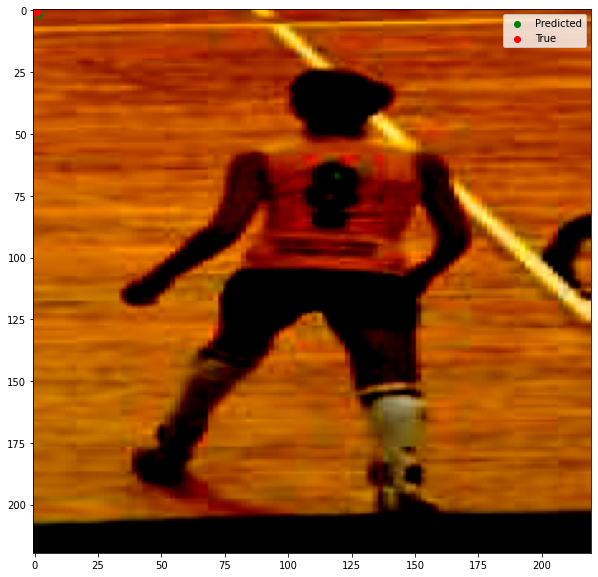

In [97]:
dataset.compare_pose(10,DeepPose,True)
# plt.imshow(dataset.data['test images'][10] , aspect='auto')
# dataset.compare_pose(100,DeepPose,False)

[138.94606 138.2581  131.55017 144.60442 146.81207 145.76505 133.86472
 128.08556 129.29834 151.30145 157.57895 155.24309 140.563   140.49144]
first
[313.39642  250.76114  193.76773  195.89055  252.19957  308.84134
 152.64845  141.09549  113.136734 113.09044  145.25739  157.22717
 100.583206  67.05334 ]
first


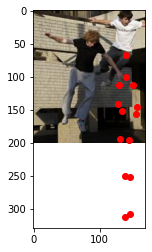

In [47]:
DeepPose.draw_pose('images/im0008.jpg')


#others

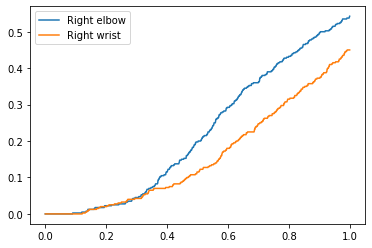

In [ ]:
dataset.test_pdj(DeepPose,['Right wrist','Right elbow'])

In [ ]:
plt.plot(DeepPose.training_log['loss'],label='Training Loss')
plt.plot(DeepPose.training_log['val_loss'],label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
# tf.keras.utils.plot_model(DeepPose.model,show_shapes=True)

In [ ]:
# image,joints=dataset.augment_images()
# joints.shape

In [ ]:
dataset.data['poses'].shape